In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, classification_report, roc_auc_score, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

plt.rcParams['font.sans-serif'] = ["SimHei"]  # 使用中文黑体
plt.rcParams['axes.unicode_minus'] = False

class data_process:
    def __init__(self, name, style):
        self.name = name # 文件名称
        self.style = style

    # 读取文件
    def read_file(self):
        if self.style == 'csv':
            self.df = pd.read_csv(self.name + '.' + self.style).dropna()
        elif self.style == 'xls' or self.style == 'xlsx':
            self.df = pd.read_excel(self.name + '.' + self.style).dropna()
        else:
            raise ValueError("仅支持 'csv'、'xlsx' 和 'xls' 格式")
        self.df['违约'] = self.df['违约'].map({1.0:1.0,2.0:0.0})    
        
    # 将离散变量转换为虚拟/指标变量
    def discrete_variance(self, df, col_name):  
        return pd.get_dummies(df, columns=[col_name], drop_first=True)*1
    
    # 标准化连续变量
    def continuous_variance(self, df, col_name):  
        df_convar = df.loc[:, col_name].copy()
        df.loc[:, col_name] = (df_convar - df_convar.mean())/df_convar.std()
        return df

    def main(self):
        try:
            self.read_file()
        except ValueError as e:
            print(f"发生错误：{e}")
         # 处理离散变量
        data = self.discrete_variance(self.df, '教育水平')
        
        # 处理连续变量
        continuous_columns = ['年龄', '工作年', '居住年', '收入', '负债率', '信用卡负债', '其他负债']
        data = self.continuous_variance(data, continuous_columns)
        
        # 保存处理后的数据
        data.to_csv('处理后的数据.csv', index=False)
        return data

data = data_process('data', 'xls').main()

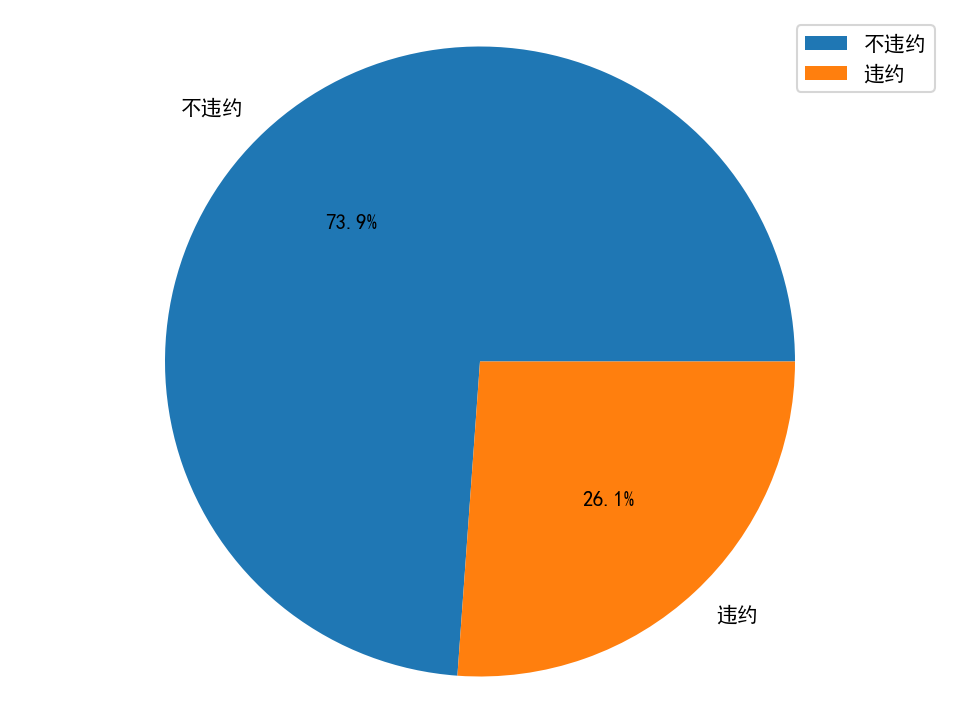

In [2]:
df1 = data.groupby('违约')['收入'].count()
df1.index = df1.index.map({1.0:'违约',0.0:'不违约'})    
# 饼状图
plt.figure(dpi=150, figsize=(8, 6))
plt.pie(df1.values, labels=df1.index, autopct='%1.1f%%')
plt.axis('equal')  # 使饼状图圆形

# 添加图例
plt.legend(df1.index, loc='upper right')
# 显示图表
plt.show()

In [3]:
class machine_learning:    
    def __init__(self, df, target_column):
        self.df = df
        if target_column not in self.df.columns:
            raise KeyError(f"{target_column}列名不存在")
        self.X = self.df.drop(columns=[target_column])
        self.y = self.df[target_column]

    def split_data(self, test_size=0.2, random_state=None):
        """
        从DataFrame中生成训练集和测试集

        参数:
        df (pd.DataFrame): 包含数据的DataFrame
        test_size (float): 测试集的比例，默认为0.2
        random_state (int): 随机种子，用于可复现性，默认为None

        返回:
        tuple: 包含训练集和测试集的元组 (X_train, X_test, y_train, y_test)
        """
        # 使用train_test_split函数分割数据集
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)

        return X_train, X_test, y_train, y_test
    
    def stepwise_selection(self, verbose=True):
        """ 基于AIC（Akaike信息准则）执行前向-后向特征选择
        参数:
            X - 带有候选特征的 pandas.DataFrame
            y - 与目标相关的类似列表
            verbose - 是否打印包含和排除的顺序
        返回: 选择的特征列表 
        """
        best_aic = 1e10
        included = []
        while True:
            changed = False
            # Forward step
            excluded = list(set(self.X.columns) - set(included))
            new_aic = pd.Series(index=excluded)
            for new_column in excluded:
                model = sm.Logit(self.y, sm.add_constant(pd.DataFrame(self.X[included + [new_column]]))).fit(disp=0)
                new_aic[new_column] = model.aic
            if best_aic > new_aic.min():
                best_aic = new_aic.min()
            if new_aic.min() < float('inf') and best_aic== new_aic.min():
                best_feature = new_aic.idxmin()
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f'Add  {best_feature} with AIC {best_aic}')
            
            # Backward step
            if included:
                model = sm.Logit(self.y, sm.add_constant(pd.DataFrame(self.X[included]))).fit(disp=0)
                # Compare AIC if removing each variable
                aic_with_var = model.aic
                for var in included:
                    model_without_var = sm.Logit(self.y, sm.add_constant(pd.DataFrame(self.X[included].drop(var, axis=1)))).fit(disp=0)
                    aic_without_var = model_without_var.aic
                    if aic_without_var < aic_with_var:
                        included.remove(var)
                        changed = True
                        aic_with_var = aic_without_var
                        if verbose:
                            print(f'Drop {var} with AIC {aic_without_var}')
                        break

            if not changed:
                break
        return included
    
    def feature_selection(self):
        predictors = self.stepwise_selection()
        print('Selected features:', predictors) 
        return predictors
    
    def LogisticRegression(self, threshold=0.5, feature_selection=True):
        if feature_selection :
            feature_selected = self.feature_selection()
            X = self.X.loc[:, feature_selected]
        else:
            X = self.X
        logistic = LogisticRegression(solver='liblinear', random_state=1, max_iter=2000)
        X_train, X_test, y_train, y_test = train_test_split(X, self.y, test_size=0.2, random_state=42)
        logistic.fit(X_train, y_train)
        
        # 在测试集上进行预测
        y_prob = logistic.predict_proba(X_test)[:, 1]

        # 根据传入的阈值进行分类
        y_pred = (y_prob >= threshold).astype(int)
        
        # 输出混淆矩阵和分类报告
        m = confusion_matrix(y_test, y_pred)
        print("测试集样本数：\n", m)
        
        report = classification_report(y_test, y_pred, target_names=['0', '1'])
        print("模型测试结果：\n", report)
        
        # 输出AUC和准确率
        y_pred_proba = logistic.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        accuracy = accuracy_score(y_test, y_pred)

        print("AUC:", auc)
        print("准确率：", accuracy)
        return auc, accuracy

    def select_best_threshold(self):
        # 创建阈值候选列表
        thresholds = np.arange(0.3, 0.7, 0.01)
        
        best_auc = 0.0
        best_accuracy = 0.0
        best_threshold = 0.0

        for threshold in thresholds:
            auc, accuracy = self.LogisticRegression(threshold=threshold)
            if accuracy > best_accuracy:
                best_auc = auc
                best_accuracy = accuracy
                best_threshold = threshold

        print(f"最佳阈值为: {best_threshold}")
        print(f"最佳AUC: {best_auc}")
        print(f"对应的准确率: {best_accuracy}")
        return best_threshold


    def LogisticRegressionl1(self):
        logistic = LogisticRegressionCV(Cs=[i for i in np.arange(0.1,5,0.05)], cv=5, penalty='l1', solver='liblinear', random_state=1, max_iter=2000)

        # 训练模型
        logistic.fit(self.X, self.y)
        # 打印选择的最佳lambda的倒数
        best_C = logistic.C_[0]  # 最佳正则化强度的倒数
        print(f"最佳的 lambda 参数值为: {best_C}")

        best_logistic = LogisticRegression(C=best_C, penalty='l1', solver='liblinear', random_state=1, max_iter=2000)
        X_train, X_test, y_train, y_test = self.split_data(test_size=0.2, random_state=42)
        best_logistic.fit(X_train, y_train)
        
        y_pred = best_logistic.predict(X_test)
        print('变量前系数', best_logistic.coef_)
        m = confusion_matrix(y_test, y_pred)
        print("测试集样本数：\n",m)
        
        report = classification_report(y_test, y_pred, target_names=['0', '1'])
        print("模型测试结果：\n", report)
        
        y_pred_proba = logistic.predict_proba(X_test)
        print("AUC:", roc_auc_score(y_test,y_pred_proba[:,1]))
        print("准确率：", accuracy_score(y_test, y_pred))

    def Support_Vector_Machine(self, kernel='linear'):
        # 将数据集分割为训练集和测试集
        X_train, X_test, y_train, y_test = self.split_data(test_size=0.2, random_state=42)

        # 创建一个SVC模型
        if kernel == "linear":
            svm_model = SVC(kernel='linear', random_state=42)
            print('使用线性核')
        elif kernel == "rbf":
            svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
            print('使用高斯核')
        elif kernel == "poly":
            svm_model = SVC(kernel='poly', random_state=42)
            print('使用多项式核')
        else:
            raise ValueError(f"未知的核函数类型: {kernel}")
        # 设置C参数的候选值范围
        param_grid = {'C': [i for i in np.arange(0.1,5,0.05)], 
                      'degree': [2, 3, 4, 5]}

        # 使用GridSearchCV执行交叉验证来选择最佳的C参数
        grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5)
        grid_search.fit(self.X, self.y)

        # 打印最佳的C参数值
        if kernel == 'poly':
            best_params = grid_search.best_params_
            print(f"最佳的参数组合为: {best_params}")

            # 使用最佳的参数组合训练最终模型
            final_svm_model = SVC(kernel='poly', degree=best_params['degree'], C=best_params['C'], random_state=42)
        else:
            best_C = grid_search.best_params_['C']
            print(f"最佳的C参数值为: {best_C}")
            
            # 使用最佳的C参数训练最终模型
            if kernel == "linear":
                final_svm_model = SVC(C=best_C, kernel='linear', random_state=42)        
            elif kernel == "rbf":
                final_svm_model = SVC(kernel='rbf', C=best_C, gamma='scale', random_state=42)
        final_svm_model.fit(X_train, y_train)

        # 在测试集上进行预测
        y_pred = final_svm_model.predict(X_test)

        # 计算模型的准确性
        accuracy = accuracy_score(y_test, y_pred)
        print(f"最终模型的准确性为: {accuracy}")

        report = classification_report(y_test, y_pred, target_names=['0', '1'])
        print("模型测试结果：\n", report)

    def Random_Forest(self):
        # 将数据集分割为训练集和测试集
        X_train, X_test, y_train, y_test = self.split_data(test_size=0.2, random_state=42)

        # 创建一个随机森林模型
        random_forest_model = RandomForestClassifier(random_state=42)

        # 设置参数的候选值范围
        param_grid = {'n_estimators': [30, 50, 80, 100, 150,], 
                      'max_depth': [None, 10, 20, 30, 40,],
                      'min_samples_split': [2, 5, 8, 10],
                      'min_samples_leaf': [1, 2, 4]}

        # 使用GridSearchCV执行交叉验证来选择最佳的参数
        grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5)
        grid_search.fit(self.X, self.y)

        # 打印最佳的参数组合
        best_params = grid_search.best_params_
        print(f"最佳的参数组合为: {best_params}")

        # 使用最佳的参数组合训练最终模型
        final_random_forest_model = RandomForestClassifier(random_state=42, **best_params)
        final_random_forest_model.fit(X_train, y_train)

        # 在测试集上进行预测
        y_pred = final_random_forest_model.predict(X_test)
        
        # 计算模型的准确性
        accuracy = accuracy_score(y_test, y_pred)
        print(f"最终模型的准确性为: {accuracy}")

        report = classification_report(y_test, y_pred)
        print(report)
        
try:
    ml = machine_learning(data, '违约')
except Exception as e:
    print(f"发生错误：{e}")

ml.LogisticRegressionl1()


最佳的 lambda 参数值为: 0.15000000000000002
变量前系数 [[ 0.         -1.11897859 -0.29288054  0.          0.45313306  0.79519229
   0.          0.          0.          0.          0.        ]]
测试集样本数：
 [[100   2]
 [ 16  22]]
模型测试结果：
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       102
           1       0.92      0.58      0.71        38

    accuracy                           0.87       140
   macro avg       0.89      0.78      0.81       140
weighted avg       0.88      0.87      0.86       140

AUC: 0.9094427244582043
准确率： 0.8714285714285714


In [4]:
best_threshold = ml.select_best_threshold()

Add  负债率 with AIC 705.4289579776823
Add  工作年 with AIC 637.0826604656063
Add  信用卡负债 with AIC 583.6362821416299
Add  居住年 with AIC 566.7316919543634
Add  年龄 with AIC 565.1760733558453
Selected features: ['负债率', '工作年', '信用卡负债', '居住年', '年龄']
测试集样本数：
 [[87 15]
 [ 8 30]]
模型测试结果：
               precision    recall  f1-score   support

           0       0.92      0.85      0.88       102
           1       0.67      0.79      0.72        38

    accuracy                           0.84       140
   macro avg       0.79      0.82      0.80       140
weighted avg       0.85      0.84      0.84       140

AUC: 0.911764705882353
准确率： 0.8357142857142857
Add  负债率 with AIC 705.4289579776823
Add  工作年 with AIC 637.0826604656063
Add  信用卡负债 with AIC 583.6362821416299
Add  居住年 with AIC 566.7316919543634
Add  年龄 with AIC 565.1760733558453
Selected features: ['负债率', '工作年', '信用卡负债', '居住年', '年龄']
测试集样本数：
 [[87 15]
 [ 8 30]]
模型测试结果：
               precision    recall  f1-score   support

           0       0.92

In [5]:
auc, accuracy = ml.LogisticRegression(best_threshold)

Add  负债率 with AIC 705.4289579776823
Add  工作年 with AIC 637.0826604656063
Add  信用卡负债 with AIC 583.6362821416299
Add  居住年 with AIC 566.7316919543634
Add  年龄 with AIC 565.1760733558453
Selected features: ['负债率', '工作年', '信用卡负债', '居住年', '年龄']
测试集样本数：
 [[96  6]
 [11 27]]
模型测试结果：
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       102
           1       0.82      0.71      0.76        38

    accuracy                           0.88       140
   macro avg       0.86      0.83      0.84       140
weighted avg       0.88      0.88      0.88       140

AUC: 0.911764705882353
准确率： 0.8785714285714286


In [6]:
auc, accuracy = ml.LogisticRegression(feature_selection=False)

测试集样本数：
 [[97  5]
 [15 23]]
模型测试结果：
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       102
           1       0.82      0.61      0.70        38

    accuracy                           0.86       140
   macro avg       0.84      0.78      0.80       140
weighted avg       0.85      0.86      0.85       140

AUC: 0.9050567595459236
准确率： 0.8571428571428571


Add  负债率 with AIC 705.4289579776823
Add  工作年 with AIC 637.0826604656063
Add  信用卡负债 with AIC 583.6362821416299
Add  居住年 with AIC 566.7316919543634
Add  年龄 with AIC 565.1760733558453
Selected features: ['负债率', '工作年', '信用卡负债', '居住年', '年龄']


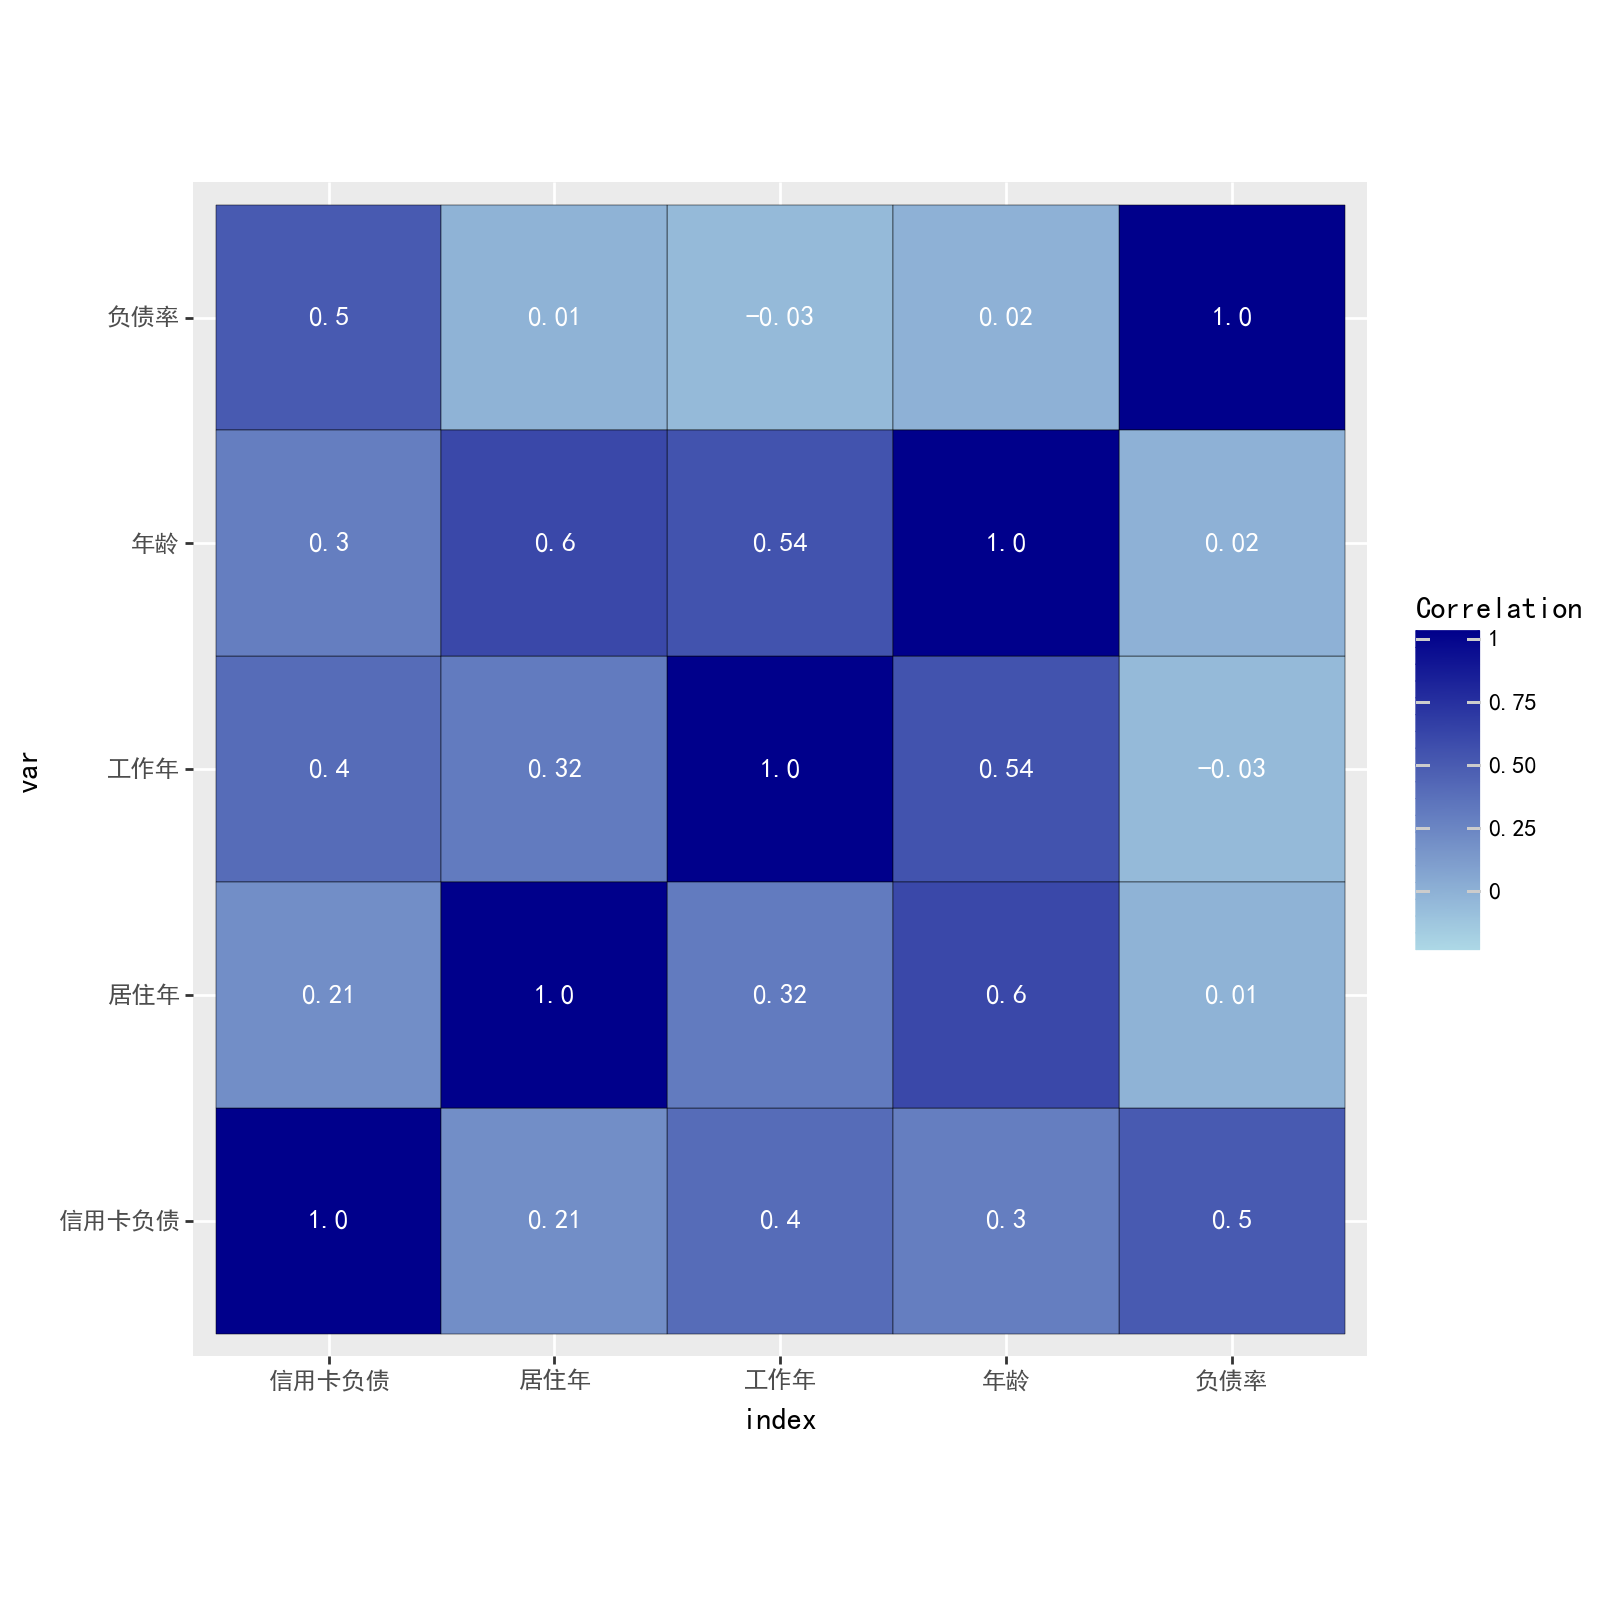

<Figure Size: (800 x 800)>

In [7]:
feature_selected = ml.feature_selection()
df2 = data.loc[:,feature_selected]
corr_matrix = np.round(df2.corr(), 2).reset_index()
mydata=pd.melt(corr_matrix,id_vars='index',var_name='var',value_name='value')
mydata['AbsValue']=np.abs(mydata.value)

(
    ggplot(mydata, aes(x='index', y='var', fill='value')) +  
    geom_tile(color="black") +
    geom_text(aes(label='value'), size=10, colour="white")+
    scale_fill_gradient(low="lightblue", high="darkblue", name="Correlation", limits=[-0.2, 1]) +  # 蓝色系的颜色映射
    coord_equal()+
    theme(dpi=100,figure_size=(8,8), text=element_text(family="SimHei"))
)

In [8]:
# 计算每个特征的VIF值
VIFs = pd.Series([variance_inflation_factor(df2.values, i) 
                for i in range(df2.shape[1])], 
                index=df2.columns)

# 输出VIF值
print(VIFs)

负债率      1.465979
工作年      1.653498
信用卡负债    1.768581
居住年      1.559510
年龄       1.965254
dtype: float64


In [9]:
ml.Support_Vector_Machine('linear')

使用线性核
最佳的C参数值为: 3.000000000000001
最终模型的准确性为: 0.8714285714285714
模型测试结果：
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       102
           1       0.92      0.58      0.71        38

    accuracy                           0.87       140
   macro avg       0.89      0.78      0.81       140
weighted avg       0.88      0.87      0.86       140



In [10]:
ml.Support_Vector_Machine('rbf')

使用高斯核
最佳的C参数值为: 1.5500000000000005
最终模型的准确性为: 0.8214285714285714
模型测试结果：
               precision    recall  f1-score   support

           0       0.82      0.97      0.89       102
           1       0.84      0.42      0.56        38

    accuracy                           0.82       140
   macro avg       0.83      0.70      0.72       140
weighted avg       0.82      0.82      0.80       140



In [11]:
ml.Support_Vector_Machine('poly')

使用多项式核
最佳的参数组合为: {'C': 3.100000000000001, 'degree': 2}
最终模型的准确性为: 0.7928571428571428
模型测试结果：
               precision    recall  f1-score   support

           0       0.79      0.98      0.87       102
           1       0.85      0.29      0.43        38

    accuracy                           0.79       140
   macro avg       0.82      0.63      0.65       140
weighted avg       0.80      0.79      0.75       140



In [12]:
ml.Random_Forest()

最佳的参数组合为: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
最终模型的准确性为: 0.8285714285714286
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89       102
         1.0       0.85      0.45      0.59        38

    accuracy                           0.83       140
   macro avg       0.84      0.71      0.74       140
weighted avg       0.83      0.83      0.81       140

